In [1]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [ ]:
%%prun # profiling

### load data
# vicsek:
#arrays.npy - normal. arrays2.npy - very few particles. arrays3.npy - high density. arrays4.npy - high density, low noise.
#arrays5.npy - small domain, one clump
#datasets = ['arrays.npy', 'arrays2.npy', 'arrays3.npy']#, 'arrays5.npy']
#datasets = ['data_bu.npy'] # burgers' equation data
## it may be interesting to reintroduce regression on multiple datasets,
## but for now we're just not going to do it

#dataset = 'data_bu.npy'
#dataset = 'data_cbu.npy'
#dataset = 'lamp2.npy'
#dataset = 'lamp2_1e-4.npy'
#dataset = 'lamp_16x.npy'
#dataset = 'lamp_16x_half.npy'
#dataset = 'dump_16h1e4.npy'
#dataset = 'dump_16h1e4g.npy'
#dataset = 'dump_10wide.npy'
dataset = 'sim_n1024_1i1.0_2i1.0.npy'
#import scipy.io
#dataset = 'gas_1000_4_0.mat'
#dataset = 'gas_1000_16_4.mat'
#dataset = 'gas_5000_24_4.mat'
#matdata = scipy.io.loadmat(dataset)
#positions = matdata['pos_data']
#vs = matdata['vs_data']
#deltat = matdata['dt'][0][0]
#dims = matdata['dims'][0]
#for i, dset in enumerate(datasets):
positions, vs, deltat, dims = load(dataset, 4)
#positions = positions[0:2, :, :]
#vs = vs[0:2, :, :]
#deltat = float(deltat)
deltat = float(deltat*8) # deltat value wrong because of subsampling
#world_size = np.array([dims[0], dims[0], dims[1]])
world_size = np.array([dims[0], dims[1], dims[2]])
print(world_size)
cg_res = 128#200 - lamp; 20 - Jason; 5 - burgers
world_size[2] = world_size[2]-1 # start at frame 2
#print(positions.shape)
positions = positions[:, :, 1:]
vs = vs[:, :, 1:]
#world_size[2] = 50 # restrict to first 50 time steps
data_dict = {}
data_dict['v'] = vs # because scaling can be wrong when outputting directly from LAMMPS
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=0.04, cg_res=cg_res, deltat=deltat, cutoff=6)
#kernel_sigma=0.01/0.04 (lamp),0.1 (Jason?),0.6 (burgers?)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
#srd.make_libraries(max_complexity=5, max_observables=4)
srd.make_libraries(max_complexity=6, max_observables=3)

dom_width = 0.25#0.2 - LJ (lamp); 1.5 - Jason; 10 - Burgers?; 80 - ?
dom_time = 20 #20 - LJ; 30/50 - Burgers
srd.make_domains(ndomains=20, domain_size=[dom_width, dom_width, dom_time], pad=0)
#srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=0)
#srd.make_domains(ndomains=1, domain_size=[dom_width, dom_width, dom_time], pad=0)
srd.make_weights(m=16, qmax=1) #qmax=1
srd.make_library_matrices(debug=False)

save('Q_bu.npy', srd.dxs, srd.libs)

[  1   1 128]


In [ ]:
_, libs = load('Q_bu.npy', 2)
libs = libs.item()

In [ ]:
import scipy.io
scipy.io.savemat('lammps_Qs.mat', {'Q0': libs[0].Q, 'Q1': libs[1].Q, 'n0': libs[0].col_weights,
                 'n1': libs[1].col_weights})

In [ ]:
from identify_models import *
opts = dict()
opts['threshold'] = "'verbose'"
opts['row_norms'] = libs[0].row_weights
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['char_sizes'] = libs[0].col_weights
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
#opts['verbose'] = True
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights
opts1['row_norms'] = libs[1].row_weights

#Q = libs[0].Q
#print(Q[:, 3]+Q[:, 14], np.linalg.norm(Q[:, 3]+Q[:, 14]), 
#np.linalg.norm(Q[:, 3]+Q[:, 14])/np.linalg.norm(Q[:, 0]))
#print(np.linalg.norm(Q[:, 0])/libs[0].col_weights[0])
#print(list(zip(libs[1].terms, libs[1].col_weights)))
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2)


#[0.15 s]
#Identified model: -0.9787526520510974 * rho + 0.028230207633854636 * rho * rho + -0.028610932601784253 * rho * rho[v_j * v_j] + 1.0 * rho[v_j * v_j] = 0 (order 5, residual 5.07e-05)
#[0.15 s]
#Identified model: -0.02837528778491848 * rho * rho + 1.0 * rho[v_j * v_j] = 0 (order 6, residual 1.43e-05)
#[0.26 s]
#Identified model: 0.9999199152531711 * dj rho[v_j] + 1.0 * dt rho = 0 (order 6, residual 3.51e-06)

-0.03249129853410361
0.8905623385416921
1.3110734750000972


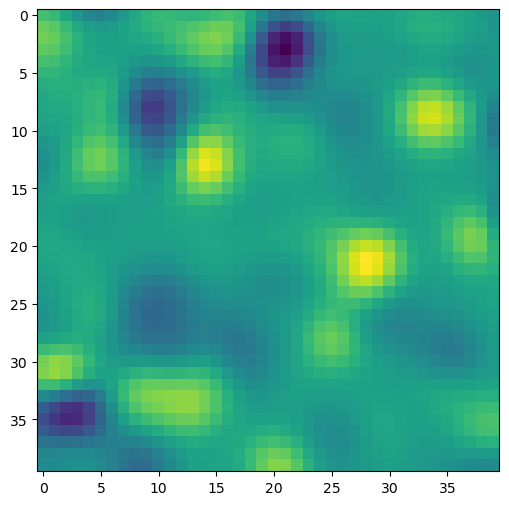

In [17]:
import matplotlib.pyplot as plt
from utils import construct_from_string as cfs
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = [0, 0, 0]
cgp = srd.cgps[-1]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(data))
print(np.mean(np.abs(data)))
print(np.std(data))

107.7019418548561
135.77091516711826
0.049793997420508045


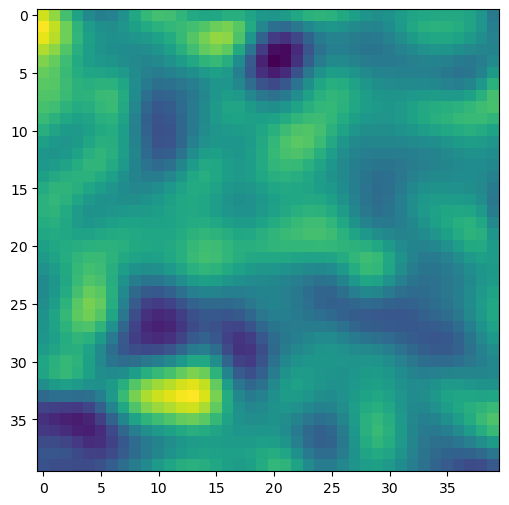

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = [0]
cgp = srd.cgps[1]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(np.abs(data)))
print(np.std(data))
print(np.std(vs[np.abs(vs)<10]))

10330.617882723074
3040.4761807963537


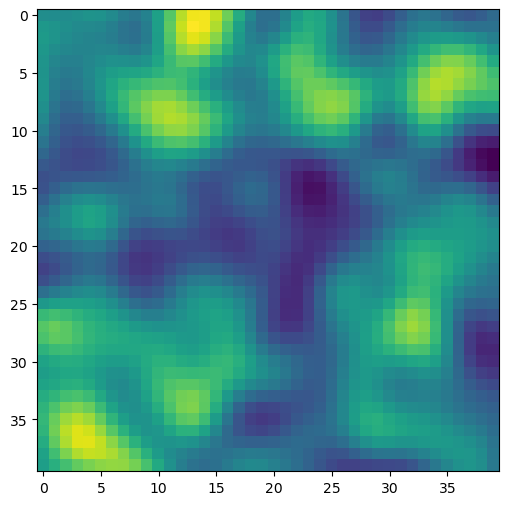

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = []
cgp = srd.cgps[0]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(np.abs(data)))
print(np.std(data))

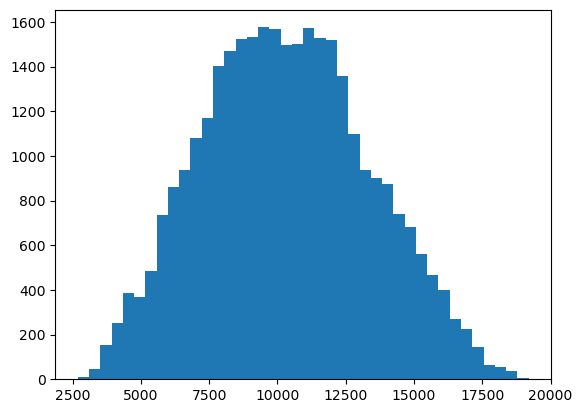

IntegrationDomain([47, 150, 82], [86, 189, 101])


In [25]:
plt.hist(data.flatten(), bins=40)
plt.show()
print(domain)

In [8]:
prts = []
for i in srd.domain_neighbors[domain, domain.times[0]]:
    prts.append(i)
print(np.std(vs[prts, :, domain.times[0]]))

0.20012994338106274


In [1]:
data = []
for domain in srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = []
cgp = srd.cgps[0]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])

SyntaxError: invalid syntax (2885799474.py, line 2)

In [11]:
print(np.mean(positions[:, 0, :]))

0.2657824533912849


In [9]:
print(np.std(vs))

0.34736777173708616


In [6]:
## mostly not planning to use this code

from ipynb.fs.full.sparse_reg import *
opts = dict()
opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
#opts['threshold'] = "'threshold'"
#opts['n_terms'] = len(terms0)
#opts['gamma'] = 1.2
opts['char_sizes'] = srd.libs[0].col_weights
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[0].Q, opts=opts)
print(srd.libs[0].Q.shape)

(240, 28)


In [8]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[0].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", srd.libs[0].terms[best_term])

[Term 19] 1.0 * rho[v_j] * rho[v_j]
Model residual: 0.0030944418121483697
One-term model residual: 1.294046607514735e-05
Best term (#6): dt^3 rho


In [ ]:
opts['verbose'] = True
opts['char_sizes'] = srd.libs[1].col_weights
opts['avoid'] = []
opts['row_norms'] = None
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[1].Q, opts=opts)
print(srd.libs[1].Q.shape)

In [ ]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[1].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", srd.libs[1].terms[best_term])

In [14]:
for term, size in zip(libs[0].terms, libs[0].col_weights):
    print(term, size)
for term, size in zip(libs[1].terms, libs[1].col_weights):
    print(term, size)

di rho 5243.694443112036
di dj^2 rho 5243.694443112036
dt di rho 5243.694443112036
dt di dj^2 rho 5243.694443112036
dt^2 di rho 5243.694443112036
dt^3 di rho 5243.694443112036
rho * di rho 26046891.458951727
rho * di dj^2 rho 26046891.458951727
rho * dt di rho 26046891.458951727
rho * dt^2 di rho 26046891.458951727
rho * rho * di rho 129382167865.5575
rho * rho * dt di rho 129382167865.5575
rho[v_i] 186.35647375428374
di dj rho[v_j] 196.72664783822557
dj^2 rho[v_i] 196.72664783822557
di dj^2 dk rho[v_k] 196.72664783822557
dj^2 dk^2 rho[v_i] 196.72664783822557
dt rho[v_i] 196.72664783822557
dt di dj rho[v_j] 196.72664783822557
dt dj^2 rho[v_i] 196.72664783822557
dt^2 rho[v_i] 196.72664783822557
dt^2 di dj rho[v_j] 196.72664783822557
dt^2 dj^2 rho[v_i] 196.72664783822557
dt^3 rho[v_i] 196.72664783822557
dt^4 rho[v_i] 196.72664783822557
rho * rho[v_i] 925684.5335309147
rho * di dj rho[v_j] 977196.0778638757
rho * dj^2 rho[v_i] 977196.0778638757
rho * dt rho[v_i] 977196.0778638757
rho * dt

In [16]:
for i in [3, 14, 13, 26, 31, 33, 68, 18, 29]:
    print(libs[1].terms[i-1])

dt di rho
di dj rho[v_j]
rho[v_i]
rho * rho[v_i]
rho * rho * rho[v_i]
rho * rho * rho * rho[v_i]
rho[v_j] * dt rho[v_i * v_j]
dt rho[v_i]
rho * dt rho[v_i]


In [11]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 3] 0.9968278263606907 * dt rho. (Char. size: 5631.272858119977)
[Term 8] 1.0 * dj rho[v_j]. (Char. size: 195.61227047686705)
Model residual: 43.71297724731395


In [12]:
from scipy.stats.stats import pearsonr 
print(np.vstack([libs[0].Q[1:10, 3],libs[0].Q[1:10, 8]]))
print(libs[0].Q[1:10, 3]+libs[0].Q[1:10, 8])
print(libs[0].Q[0, 0])
print(pearsonr(libs[0].Q[1:10, 3], libs[0].Q[1:10, 8]))
print(np.mean(np.abs(libs[0].Q[:, 3]+libs[0].Q[:, 8])))
print('density:', np.mean(libs[0].Q[:, 1]/libs[0].Q[:, 0]), '+-', 
      np.std(libs[0].Q[:, 1]/libs[0].Q[:, 0])/np.sqrt(30))
print('ratio:', -np.mean(libs[0].Q[:, 3]/libs[0].Q[:, 8]), '+-', 
      np.std(libs[0].Q[:, 3]/libs[0].Q[:, 8])/np.sqrt(30))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.13380247e+05
  -1.26070880e-34  4.55955703e+05 -8.65017686e-32 -1.35749173e+06
   8.33999928e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.06139303e+05
   1.57214943e-34 -4.59057133e+05  8.37603051e-30  1.35960531e+06
  -8.32631484e+05]]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.24094417e+03
  3.11440633e-35 -3.10143033e+03  8.28952874e-30  2.11357910e+03
  1.36844333e+03]
293.374863508793
(-0.9999897436875416, 1.1376326992464478e-17)
2730.328982074233
density: 4197.040407508196 +- 881.555275962474
ratio: nan +- nan


C:\Users\nerpa\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\nerpa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [13]:
print(np.linalg.norm(libs[0].Q[:, :], axis=0)/libs[0].col_weights)

[1.60688031e+03 2.06597757e+03 2.06140737e+06 6.12239700e+02
 1.54698237e+04 4.96925672e+03 1.66688640e+03 1.38242612e+04
 1.75692071e+04 4.33909304e+05 4.36979969e+03 4.47815747e+04
 7.93437988e+02]


In [9]:
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['rho[v_i]', 'rho[v_i * v_j * v_j]']
#burger_terms = ['rho * dt rv_i', 'dj rv_i * rv_j']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 6] 0.229149593949794 * dt rho[v_i]. (Char. size: 2923.728913619608)
[Term 10] 1.0 * dj rho[v_i * v_j]. (Char. size: 3754.447738523255)
Model residual: 0.009518828763897036


In [14]:
### not fixed (obviously)
#veqconst_terms = ['1', 'v_j * v_j']
veqconst_terms = ['rho', 'rho * v_j * v_j']
col_numbers = [find_term(terms0, name) for name in veqconst_terms]
Xi, lambd = regress(Q0, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}. (Char. size: {char_sizes0[i]})")
print("Model residual:", lambd)

[Term 16] -0.004286563115825593 * rho. (Char. size: 0.1464261231728444)
[Term 28] 1.0 * rho * v_j * v_j. (Char. size: 0.0005121399208783936)
Model residual: 0.0005697337514007149


In [ ]:
rho dt^2 v = 10^-4 dt rho * grad rho